# Building an AI-powered multimodal RAG system with Docling
*Using IBM Granite vision, text-based embeddings and generative AI models*


## Lab 3: From Documents to Transparent AI - The Complete Journey

Welcome to the final lab in our Docling workshop series! You've come a long way:
- **Lab 1**: You learned to convert documents while preserving structure
- **Lab 2**: You mastered intelligent chunking strategies
- **Lab 3**: Now, we'll build a complete, production-ready RAG system with a game-changing feature: visual grounding

This lab represents the culmination of everything you've learned, showing how Docling enables not just document processing, but truly transparent AI systems.

## Why This Lab Matters

Traditional RAG systems have a trust problem. When an AI provides information, users often wonder:
- "Where did this information come from?"
- "Can I verify this is accurate?"
- "Is the AI hallucinating or using real data?"

**Visual grounding solves this problem** by showing users exactly where information was retrieved from in the original documents. This isn't just a nice-to-have feature - it's essential for:
-  **Healthcare**: Verify medical information sources
-  **Legal**: Trace citations to exact document locations
-  **Financial**: Audit AI-generated financial insights
-  **Research**: Validate scientific claims
-  **Enterprise**: Build trustworthy internal AI systems

## What Makes This Lab Special

We're not just building another RAG system. We're creating a **multimodal RAG system with visual grounding** that:

1. **Processes Multiple Data Types**: Text, tables, and images from your documents
2. **Shows Exact Sources**: Highlights the precise location of retrieved information
3. **Understands Images**: Uses AI vision models to comprehend visual content
4. **Maintains Transparency**: Every answer can be visually verified


---


## Understanding Multimodal RAG with Visual Grounding


### What is Multimodal RAG?

[Retrieval-augmented generation (RAG)](https://www.ibm.com/think/topics/retrieval-augmented-generation) is a technique used with large language models (LLMs) to connect the model with a knowledge base of information outside the data the LLM has been trained on without having to perform [fine-tuning](https://www.ibm.com/think/topics/rag-vs-fine-tuning). Traditional RAG is limited to text-based use cases such as text summarization and chatbots.

Traditional RAG systems only handle text. But real documents contain:
- **Text**: Paragraphs, lists, headers
- **Tables**: Structured data, financial information
- **Images**: Charts, diagrams, photos, illustrations

Multimodal RAG can use [multimodal LLMs](https://www.ibm.com/think/topics/multimodal-ai) (MLLM) to process information from multiple types of data to be included as part of the external knowledge base used in RAG. Multimodal data can include text, images, audio, video or other forms.


### Visual Grounding: The Transparency Layer

Visual grounding adds a crucial transparency layer to RAG systems. When the system retrieves information to answer a query, it doesn't just return text - it shows you exactly where in the original document that information came from by:
- Drawing bounding boxes on document pages
- Highlighting specific regions
- Labeling content types (TEXT, TABLE, IMAGE)
- Using different colors for multiple sources

For this recipe, you will use IBM Granite models capable of processing different modalities, enhanced with Docling's visual grounding capabilities to create a transparent, verifiable AI system.

---


## Recipe Overview

In this comprehensive lab, you'll learn how to:

1. **Configure Docling for Visual Grounding**: Set up document processing to maintain visual references
2. **Process Multimodal Content**: Handle text, tables, and images with proper metadata
3. **Leverage AI Vision Models**: Use IBM Granite vision models to understand images
4. **Build a Vector Database**: Store embeddings with visual grounding metadata
5. **Implement Visual Attribution**: Show users exactly where information comes from
6. **Create a Complete RAG Pipeline**: Combine all components into a production-ready system

### Technologies We'll Use

Building on our previous labs, we'll add:

1. **[Docling](https://docling-project.github.io/docling/):** An open-source toolkit used to parse and convert documents.
2. **[LangChain](https://langchain.com)**: For orchestrating the RAG pipeline
3. **[IBM Granite Vision Models](https://www.ibm.com/granite/)**: For understanding image content
4. **Visual Grounding**: Docling's unique capability for source attribution


---

## Prerequisites

Before we begin, ensure you have:
- Completed Labs 1 and 2 (or equivalent Docling knowledge)
- Python 3.10, 3.11, or 3.12 installed
- Basic understanding of embeddings and vector databases
- Familiarity with the concepts from previous labs

## Setting up the environment

Ensure you are running Python 3.10, 3.11 or 3.12 in a freshly created virtual environment.

In [1]:
import sys
assert sys.version_info >= (3, 10) and sys.version_info < (3, 13), "Use Python 3.10, 3.11, or 3.12 to run this notebook."

## Install Dependencies

Now let's install all necessary packages. Note that we're building on the packages from previous labs and adding vision and RAG-specific components:

In [ ]:
! echo "::group::Install Dependencies"
%pip install uv
! uv pip install "git+https://github.com/ibm-granite-community/utils.git" \
    transformers \
    pillow \
    langchain_community \
    'langchain_huggingface[full]' \
    langchain_milvus 'pymilvus[milvus_lite]'\
    docling \
    replicate \
    matplotlib
! echo "::endgroup::"

## Import Required Libraries and Configure Logging


### Logging Configuration

To see detailed information about the document processing and visual grounding operations, we'll configure INFO log level.

NOTE: It is okay to skip running this cell if you prefer less verbose output.

In [2]:
import logging

logging.basicConfig(level=logging.INFO)

### Required Libraries

Now let's import all necessary modules, organized by their purpose:


In [3]:
import json
import base64
import io
import itertools
import tempfile
from pathlib import Path
from tempfile import mkdtemp
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import PIL.ImageOps
from PIL import ImageDraw
from IPython.display import display

# Docling imports for document processing and visual grounding
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions
from docling.datamodel.document import DoclingDocument
from docling.chunking import DocMeta
from docling_core.transforms.chunker.hybrid_chunker import HybridChunker
from docling_core.types.doc.document import TableItem, RefItem
from docling_core.types.doc.labels import DocItemLabel

# LangChain imports for RAG pipeline
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.llms import Replicate
from langchain_core.documents import Document
from langchain_core.vectorstores import VectorStore
from langchain_milvus import Milvus
from langchain.prompts import PromptTemplate
from langchain.chains.retrieval import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

# Model imports
from transformers import AutoTokenizer, AutoProcessor
from ibm_granite_community.notebook_utils import get_env_var, escape_f_string

/Users/simon/Documents/projects/202510-pycones-docling-workshop/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---

## Selecting and loading the AI models

### The Three Pillars of Multimodal RAG

For a complete multimodal RAG system with visual grounding, we need three types of models, each serving a crucial purpose:

1. **Embeddings Model**: Converts text into vector representations
   - Enables semantic search ("find content similar in meaning")
   - Must handle text from chunks, tables, and image descriptions

2. **Vision Model**: Understands and describes visual content
   - Processes images found in documents
   - Generates textual descriptions for retrieval

3. **Language Model**: Generates final responses
   - Synthesizes retrieved information
   - Produces coherent, accurate answers

### Load the Granite Embeddings Model

We'll use the [Granite Embeddings model](https://huggingface.co/collections/ibm-granite/granite-embedding-models-6750b30c802c1926a35550bb) for generating text embedding vectors.

**Why this model**:
- Optimized for English text
- Compact (107m parameters) for fast processing
- Excellent semantic understanding
- 512 token context window

To use a different embeddings model, you can refer to [this Embeddings Model recipe](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Components/Langchain_Embeddings_Models.ipynb).

In [11]:
embeddings_model_path = "ibm-granite/granite-embedding-107m-multilingual"
embeddings_model = HuggingFaceEmbeddings(
    model_name=embeddings_model_path,
)
embeddings_tokenizer = AutoTokenizer.from_pretrained(embeddings_model_path)
print(f"Embeddings model loaded: {embeddings_model_path}")

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: ibm-granite/granite-embedding-107m-multilingual


Embeddings model loaded: ibm-granite/granite-embedding-107m-multilingual


### Load the Granite Vision Model

The vision model will help us understand images within documents. This is crucial for truly multimodal RAG as many documents contain important visual information.

**Why use a hosted model**:
- Faster processing without local GPU requirements
- Consistent performance
- Easy to scale

**Note**: To set up Replicate, see [Getting Started with Replicate](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Getting_Started/Getting_Started_with_Replicate.ipynb).


To connect to a model on a provider other than Replicate, see the [LLM component recipe](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Components/Langchain_LLMs.ipynb).

In [12]:
vision_model_path = "ibm-granite/granite-vision-3.3-2b"
vision_model = Replicate(
    model=vision_model_path,
    replicate_api_token=get_env_var("REPLICATE_API_TOKEN"),
    model_kwargs={
        "max_tokens": embeddings_tokenizer.max_len_single_sentence,
        "min_tokens": 100,
        "temperature": 0.01 # low temperature for reproduceability
    },
)
vision_processor = AutoProcessor.from_pretrained(vision_model_path)
print(f"Vision model loaded: {vision_model_path}")

Vision model loaded: ibm-granite/granite-vision-3.3-2b


### Load the Granite Language Model

Finally, our language model will generate responses based on retrieved context.

**Why this model**:
- 8B parameters: Good balance of quality and speed
- Instruction-tuned: Follows prompts accurately
- Granite family: Open-source and Apache 2.0 licensed

In [7]:
model_path = "ibm-granite/granite-3.3-8b-instruct"
model = Replicate(
    model=model_path,
    replicate_api_token=get_env_var("REPLICATE_API_TOKEN"),
    model_kwargs={
        "max_tokens": 1000,
        "min_tokens": 100,
        "temperature": 0.01 # low temperature for reproduceability

    },
)
tokenizer = AutoTokenizer.from_pretrained(model_path)
print(f"Language model loaded: {model_path}")

Language model loaded: ibm-granite/granite-3.3-8b-instruct



---


## Enhanced document processing with visual grounding support

### The Foundation of Visual Grounding

Visual grounding requires special configuration during document conversion. Unlike standard processing, we need to:

1. **Generate high-quality page images**: For displaying visual highlights
2. **Preserve coordinate information**: To know where content is located
3. **Maintain document structure**: For accurate source attribution
4. **Store documents properly**: For later retrieval and visualization

Let's configure Docling with these requirements:


In [13]:
# Configure converter with visual grounding capabilities
pdf_pipeline_options = PdfPipelineOptions(
    do_ocr=False,  # Set to True if your PDFs contain scanned images
    generate_picture_images=True,  # Extract images from documents
    generate_page_images=True,  # CRITICAL: Generate page images for visual grounding
)

format_options = {
    InputFormat.PDF: PdfFormatOption(pipeline_options=pdf_pipeline_options),
}

converter = DocumentConverter(format_options=format_options)
print("Document converter configured with visual grounding support")

Document converter configured with visual grounding support


### Create a Document Store for Visual Grounding

The document store will maintain the full document structure needed for visual grounding. This is essential for highlighting source locations later:

In [14]:
# Create document store for visual grounding
doc_store = {}
doc_store_root = Path(mkdtemp())
print(f"Document store created at: {doc_store_root}")

Document store created at: /var/folders/cf/wmcbk_7j29z_ts8842l_v6q40000gn/T/tmp88p_djsr


### Convert Documents with Visual Tracking

Now let's process documents while preserving all information needed for visual grounding:


In [15]:
sources = [
    "https://midwestfoodbank.org/images/AR_2020_WEB2.pdf",
    # Add more document URLs here as needed
]

conversions = {}

print("Starting document conversion with visual grounding support...")
for source in sources:
    print(f"\n Processing: {source}")

    # Convert document
    result = converter.convert(source=source)
    docling_document = result.document
    conversions[source] = docling_document

    # Save document to store for visual grounding
    # The binary hash ensures unique identification
    file_path = doc_store_root / f"{docling_document.origin.binary_hash}.json"
    docling_document.save_as_json(file_path)
    doc_store[docling_document.origin.binary_hash] = file_path

    print(f"Document converted and saved")
    print(f"  - Document ID: {docling_document.origin.binary_hash}")
    print(f"  - Pages: {len(docling_document.pages)}")
    print(f"  - Tables: {len(docling_document.tables)}")
    print(f"  - Images: {len(docling_document.pictures)}")

Starting document conversion with visual grounding support...

 Processing: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf


INFO:docling.datamodel.document:detected formats: [<InputFormat.PDF: 'pdf'>]
INFO:docling.document_converter:Going to convert document batch...
INFO:docling.document_converter:Initializing pipeline for StandardPdfPipeline with options hash d623d6d7f1219cdd27e2b90d40798204
INFO:docling.utils.accelerator_utils:Accelerator device: 'mps'
INFO:docling.utils.accelerator_utils:Accelerator device: 'mps'
INFO:docling.pipeline.base_pipeline:Processing document AR_2020_WEB2.pdf
INFO:docling.document_converter:Finished converting document AR_2020_WEB2.pdf in 10.14 sec.


Document converted and saved
  - Document ID: 17413939357152681290
  - Pages: 20
  - Tables: 2
  - Images: 53


## Process Document Content with Visual Grounding Metadata


### The Importance of Metadata Preservation

For visual grounding to work, every chunk of content must maintain metadata about its source location. This includes:
- **Page numbers**: Which page(s) contain this content
- **Bounding boxes**: Exact coordinates on the page
- **Document references**: Links back to the source document
- **Content type**: Whether it's text, table, or image

This metadata is what enables us to draw accurate highlights on document pages later.


### Process Text Chunks with Location Tracking


Next we process any tables in the documents. We convert the table data to markdown format for passing into the language model. A list of LangChain documents are created from the table's markdown renderings.

In [16]:
from docling.chunking import DocMeta

doc_id = 0
texts: list[Document] = []

print("\nProcessing text chunks with visual grounding metadata...")
for source, docling_document in conversions.items():
    chunker = HybridChunker(tokenizer=embeddings_tokenizer)

    for chunk in chunker.chunk(docling_document):
        items = chunk.meta.doc_items

        # Skip single-item chunks that are tables (we'll process them separately)
        if len(items) == 1 and isinstance(items[0], TableItem):
            continue

        refs = " ".join(map(lambda item: item.get_ref().cref, items))
        text = chunk.text

        # Create document with enhanced metadata for visual grounding
        document = Document(
            page_content=text,
            metadata={
                "doc_id": (doc_id:=doc_id+1),
                "source": source,
                "ref": refs,  # References for tracking specific document items
                "dl_meta": chunk.meta.model_dump(),  # CRITICAL: Store chunk metadata for visual grounding
                "origin_hash": docling_document.origin.binary_hash  # Link to stored document
            },
        )
        texts.append(document)

print(f"Created {len(texts)} text chunks with visual grounding metadata")


Processing text chunks with visual grounding metadata...


Token indices sequence length is longer than the specified maximum sequence length for this model (691 > 512). Running this sequence through the model will result in indexing errors


Created 72 text chunks with visual grounding metadata


### Process Tables with Spatial Information

Tables require special handling to preserve their structure and location:

In [17]:
doc_id = len(texts)
tables: list[Document] = []

print("\nProcessing tables...")
for source, docling_document in conversions.items():
    for table in docling_document.tables:
        if table.label in [DocItemLabel.TABLE]:
            ref = table.get_ref().cref
            text = table.export_to_markdown(docling_document)

            # Extract provenance information for visual grounding
            prov_data = []
            if hasattr(table, 'prov') and table.prov:
                for prov in table.prov:
                    # Get the page to access its height for coordinate conversion
                    if prov.page_no < len(docling_document.pages):
                        page = docling_document.pages[prov.page_no]
                        # Convert to top-left origin and normalize
                        bbox = prov.bbox.to_top_left_origin(page_height=page.size.height)
                        bbox_norm = bbox.normalized(page.size)

                        prov_data.append({
                           "page_no": prov.page_no,
                           "bbox": {
                              "l": bbox_norm.l,  # Use normalized coordinates
                              "t": bbox_norm.t,
                              "r": bbox_norm.r,
                              "b": bbox_norm.b
                        }
                    })

            document = Document(
                page_content=text,
                metadata={
                    "doc_id": (doc_id:=doc_id+1),
                    "source": source,
                    "ref": ref,
                    "origin_hash": docling_document.origin.binary_hash,
                    "item_type": "table",  # Mark as table
                    "prov_data": prov_data  # Store provenance as simple data
                },
            )
            tables.append(document)

print(f"Created {len(tables)} table documents")


Processing tables...
Created 1 table documents


In [20]:
print(tables[0].page_content)

| PUBLIC SUPPORT AND REVENUE                      | 2018         | 2019         | 2020*        |
|-------------------------------------------------|--------------|--------------|--------------|
| Donated food, vehicles, equipment and services  | $229,928,875 | $270,649,371 | $397,204,944 |
| General public contributions and grants         | $7,436,910   | $7,487,187   | $18,427,058  |
| Special events                                  | $788,242     | $809,831     | $864,259     |
| CARES and Other*                                | $94,829      | $67,262      | $2,706,416   |
| Total public support and revenue                | $238,248,856 | $279,013,656 | $419,202,677 |
| EXPENSES                                        |              |              |              |
| Program services                                | $232,260,156 | $279,505,173 | $392,370,479 |
| Management and general                          | $1,123,151   | $988,014     | $1,278,165   |
| Fundraising                 

### Process Images with Vision Understanding

For true multimodal RAG, we need to understand the content of images. We'll use the Granite vision model to generate descriptions.


NOTE: Processing images can take time depending on the number of images and the vision model service. Each image will be analyzed individually.

In [21]:
def encode_image(image: PIL.Image.Image, format: str = "png") -> str:
    """Encode image to base64 for vision model processing"""
    image = PIL.ImageOps.exif_transpose(image) or image
    image = image.convert("RGB")

    buffer = io.BytesIO()
    image.save(buffer, format)
    encoding = base64.b64encode(buffer.getvalue()).decode("utf-8")
    uri = f"data:image/{format};base64,{encoding}"
    return uri

# Configure vision prompt - feel free to experiment with this!
image_prompt = "Give a detailed description of what is depicted in the image"
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": image_prompt},
        ],
    },
]
vision_prompt = vision_processor.apply_chat_template(
    conversation=conversation,
    add_generation_prompt=True,
)

pictures: list[Document] = []
doc_id = len(texts) + len(tables)

for source, docling_document in conversions.items():
    num_pictures = len(docling_document.pictures)
    for i, picture in enumerate(docling_document.pictures):
        ref = picture.get_ref().cref
        print(f"  Processing image: {ref} ({i+1}/{num_pictures})")

        image = picture.get_image(docling_document)
        if image:
            # Generate image description using vision model
            text = vision_model.invoke(vision_prompt, image=encode_image(image))

            # Extract provenance information for visual grounding
            prov_data = []
            if hasattr(picture, 'prov') and picture.prov:
                for prov in picture.prov:
                    # Get the page to access its height for coordinate conversion
                    if prov.page_no < len(docling_document.pages):
                        page = docling_document.pages[prov.page_no]
                        # Convert to top-left origin and normalize
                        bbox = prov.bbox.to_top_left_origin(page_height=page.size.height)
                        bbox_norm = bbox.normalized(page.size)

                        prov_data.append({
                            "page_no": prov.page_no,
                            "bbox": {
                                "l": bbox_norm.l,
                                "t": bbox_norm.t,
                                "r": bbox_norm.r,
                                "b": bbox_norm.b
                            }
                        })

            document = Document(
                page_content=text,
                metadata={
                    "doc_id": (doc_id:=doc_id+1),
                    "source": source,
                    "ref": ref,
                    "origin_hash": docling_document.origin.binary_hash,
                    "item_type": "picture",  # Mark as picture for special handling
                    "prov_data": prov_data  # Store normalized provenance data
                },
            )
            pictures.append(document)

print(f"Created {len(pictures)} image descriptions")

  Processing image: #/pictures/0


INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/7a59q6gk0srmc0csvxf9ggtpbg "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/7a59q6gk0srmc0csvxf9ggtpbg "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/7a59q6gk0srmc0csvxf9ggtpbg "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/7a59q6gk0srmc0csvxf9ggtpbg "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/7a59q6gk0srmc0csvxf9ggtpbg "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/7a59q6gk0srmc0csvxf9ggtpbg "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/

  Processing image: #/pictures/1


INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/ka4a3d1bsxrmc0csvxf9k4yv34 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/ka4a3d1bsxrmc0csvxf9k4yv34 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/ka4a3d1bsxrmc0csvxf9k4yv34 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/ka4a3d1bsxrmc0csvxf9k4yv34 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/ka4a3d1bsxrmc0csvxf9k4yv34 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/ka4a3d1bsxrmc0csvxf9k4yv34 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/ka4a3d1bsxrmc0csvxf9k4yv34 "HTTP/1.1 200 OK"


  Processing image: #/pictures/2


INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/pn4zq3sxk5rma0csvxf986wsp8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/pn4zq3sxk5rma0csvxf986wsp8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/pn4zq3sxk5rma0csvxf986wsp8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/pn4zq3sxk5rma0csvxf986wsp8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/pn4zq3sxk5rma0csvxf986wsp8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/pn4zq3sxk5rma0csvxf986wsp8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/pn4zq3sxk5rma0csvxf986wsp8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/pr

  Processing image: #/pictures/3


INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/cehpgxaj0srme0csvxf9ecz1rw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/cehpgxaj0srme0csvxf9ecz1rw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/cehpgxaj0srme0csvxf9ecz1rw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/cehpgxaj0srme0csvxf9ecz1rw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/cehpgxaj0srme0csvxf9ecz1rw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/cehpgxaj0srme0csvxf9ecz1rw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/cehpgxaj0srme0csvxf9ecz1rw "HTTP/1.1 200 OK"


  Processing image: #/pictures/4


INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/7jhmm3b44hrmc0csvxf9d84czr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/7jhmm3b44hrmc0csvxf9d84czr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/7jhmm3b44hrmc0csvxf9d84czr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/7jhmm3b44hrmc0csvxf9d84czr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/7jhmm3b44hrmc0csvxf9d84czr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/7jhmm3b44hrmc0csvxf9d84czr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/7jhmm3b44hrmc0csvxf9d84czr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/pr

  Processing image: #/pictures/5


INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/d9149zbwpsrma0csvxf9385ekm "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/d9149zbwpsrma0csvxf9385ekm "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/d9149zbwpsrma0csvxf9385ekm "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/d9149zbwpsrma0csvxf9385ekm "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/d9149zbwpsrma0csvxf9385ekm "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/d9149zbwpsrma0csvxf9385ekm "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/d9149zbwpsrma0csvxf9385ekm "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/pr

  Processing image: #/pictures/6


INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/38k480ck7nrmc0csvxf9v8vjeg "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/38k480ck7nrmc0csvxf9v8vjeg "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/38k480ck7nrmc0csvxf9v8vjeg "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/38k480ck7nrmc0csvxf9v8vjeg "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/38k480ck7nrmc0csvxf9v8vjeg "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/38k480ck7nrmc0csvxf9v8vjeg "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/38k480ck7nrmc0csvxf9v8vjeg "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/38k480ck7nrmc0csvxf9v8vjeg "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/38k480ck7n

  Processing image: #/pictures/7


INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vw7jhvdchdrma0csvxf8r7rqx4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vw7jhvdchdrma0csvxf8r7rqx4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vw7jhvdchdrma0csvxf8r7rqx4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vw7jhvdchdrma0csvxf8r7rqx4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vw7jhvdchdrma0csvxf8r7rqx4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vw7jhvdchdrma0csvxf8r7rqx4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vw7jhvdchdrma0csvxf8r7rqx4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/pr

  Processing image: #/pictures/8


INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/xdmyt2p5m5rma0csvxfaapxnhm "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/xdmyt2p5m5rma0csvxfaapxnhm "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/xdmyt2p5m5rma0csvxfaapxnhm "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/xdmyt2p5m5rma0csvxfaapxnhm "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/xdmyt2p5m5rma0csvxfaapxnhm "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/xdmyt2p5m5rma0csvxfaapxnhm "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/xdmyt2p5m5rma0csvxfaapxnhm "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/pr

  Processing image: #/pictures/9


INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/79vbz5pxbxrme0csvxf8b6v26r "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/79vbz5pxbxrme0csvxf8b6v26r "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/79vbz5pxbxrme0csvxf8b6v26r "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/79vbz5pxbxrme0csvxf8b6v26r "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/79vbz5pxbxrme0csvxf8b6v26r "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/79vbz5pxbxrme0csvxf8b6v26r "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/79vbz5pxbxrme0csvxf8b6v26r "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"


  Processing image: #/pictures/10


INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/ht8gr1zf5drme0csvxf9rh8dg4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/ht8gr1zf5drme0csvxf9rh8dg4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/ht8gr1zf5drme0csvxf9rh8dg4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/ht8gr1zf5drme0csvxf9rh8dg4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/ht8gr1zf5drme0csvxf9rh8dg4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/ht8gr1zf5drme0csvxf9rh8dg4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"


  Processing image: #/pictures/11


INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/gwhdz6qy5xrma0csvxf8d9nf9c "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/gwhdz6qy5xrma0csvxf8d9nf9c "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/gwhdz6qy5xrma0csvxf8d9nf9c "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/gwhdz6qy5xrma0csvxf8d9nf9c "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/gwhdz6qy5xrma0csvxf8d9nf9c "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/gwhdz6qy5xrma0csvxf8d9nf9c "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/gwhdz6qy5xrma0csvxf8d9nf9c "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/gwhdz6qy5xrma0csvxf8d9nf9c "HTTP/1.1 200 OK"


  Processing image: #/pictures/12


INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/mk2xx60j9nrma0csvxfvq99vh4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/mk2xx60j9nrma0csvxfvq99vh4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/mk2xx60j9nrma0csvxfvq99vh4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/mk2xx60j9nrma0csvxfvq99vh4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/mk2xx60j9nrma0csvxfvq99vh4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/mk2xx60j9nrma0csvxfvq99vh4 "HTTP/1.1 200 OK"


  Processing image: #/pictures/13


INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/gqryc7s265rmc0csvxfr8z4ymc "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/gqryc7s265rmc0csvxfr8z4ymc "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/gqryc7s265rmc0csvxfr8z4ymc "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/gqryc7s265rmc0csvxfr8z4ymc "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/gqryc7s265rmc0csvxfr8z4ymc "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/gqryc7s265rmc0csvxfr8z4ymc "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/gqryc7s265rmc0csvxfr8z4ymc "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/pr

  Processing image: #/pictures/14


INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/zkzh0z1rwnrma0csvxfv672mpc "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/zkzh0z1rwnrma0csvxfv672mpc "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/zkzh0z1rwnrma0csvxfv672mpc "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/zkzh0z1rwnrma0csvxfv672mpc "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/zkzh0z1rwnrma0csvxfv672mpc "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/zkzh0z1rwnrma0csvxfv672mpc "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/zkzh0z1rwnrma0csvxfv672mpc "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/zkzh0z1rwnrma0csvxfv672mpc "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/zkzh0z1rwn

  Processing image: #/pictures/15


INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/zk2zk1tfdnrme0csvxftaszpy4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/zk2zk1tfdnrme0csvxftaszpy4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/zk2zk1tfdnrme0csvxftaszpy4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/zk2zk1tfdnrme0csvxftaszpy4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/zk2zk1tfdnrme0csvxftaszpy4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/zk2zk1tfdnrme0csvxftaszpy4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/zk2zk1tfdnrme0csvxftaszpy4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/zk2zk1tfdnrme0csvxftaszpy4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/zk2zk1tfdn

  Processing image: #/pictures/16


INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/mmhhjzb8ddrme0csvxfr9vtpem "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/mmhhjzb8ddrme0csvxfr9vtpem "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/mmhhjzb8ddrme0csvxfr9vtpem "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/mmhhjzb8ddrme0csvxfr9vtpem "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/mmhhjzb8ddrme0csvxfr9vtpem "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/mmhhjzb8ddrme0csvxfr9vtpem "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/mmhhjzb8ddrme0csvxfr9vtpem "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/mmhhjzb8ddrme0csvxfr9vtpem "HTTP/1.1 200 OK"


  Processing image: #/pictures/17


INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/dthbxw3x5srmc0csvxfvx4gxd0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/dthbxw3x5srmc0csvxfvx4gxd0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/dthbxw3x5srmc0csvxfvx4gxd0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/dthbxw3x5srmc0csvxfvx4gxd0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/dthbxw3x5srmc0csvxfvx4gxd0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/dthbxw3x5srmc0csvxfvx4gxd0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/dthbxw3x5srmc0csvxfvx4gxd0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/pr

  Processing image: #/pictures/18


INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vfz6etcm5drme0csvxfs163cgc "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vfz6etcm5drme0csvxfs163cgc "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vfz6etcm5drme0csvxfs163cgc "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vfz6etcm5drme0csvxfs163cgc "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vfz6etcm5drme0csvxfs163cgc "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vfz6etcm5drme0csvxfs163cgc "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vfz6etcm5drme0csvxfs163cgc "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/pr

  Processing image: #/pictures/19


INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/kd97185az1rm80csvxfv57gbw8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/kd97185az1rm80csvxfv57gbw8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/kd97185az1rm80csvxfv57gbw8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/kd97185az1rm80csvxfv57gbw8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/kd97185az1rm80csvxfv57gbw8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/kd97185az1rm80csvxfv57gbw8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/kd97185az1rm80csvxfv57gbw8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/kd97185az1rm80csvxfv57gbw8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/kd97185az1

  Processing image: #/pictures/20


INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/xv5cene2fhrmc0csvxftw8w50g "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/xv5cene2fhrmc0csvxftw8w50g "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/xv5cene2fhrmc0csvxftw8w50g "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/xv5cene2fhrmc0csvxftw8w50g "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/xv5cene2fhrmc0csvxftw8w50g "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/xv5cene2fhrmc0csvxftw8w50g "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/xv5cene2fhrmc0csvxftw8w50g "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/pr

  Processing image: #/pictures/21


INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/f39b2gps31rma0csvxftz7swr8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/f39b2gps31rma0csvxftz7swr8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/f39b2gps31rma0csvxftz7swr8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/f39b2gps31rma0csvxftz7swr8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/f39b2gps31rma0csvxftz7swr8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/f39b2gps31rma0csvxftz7swr8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/f39b2gps31rma0csvxftz7swr8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/pr

  Processing image: #/pictures/22


INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/498tdgzge9rm80csvxfr4jb29m "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/498tdgzge9rm80csvxfr4jb29m "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/498tdgzge9rm80csvxfr4jb29m "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/498tdgzge9rm80csvxfr4jb29m "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/498tdgzge9rm80csvxfr4jb29m "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/498tdgzge9rm80csvxfr4jb29m "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/498tdgzge9rm80csvxfr4jb29m "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/pr

  Processing image: #/pictures/23


INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/aqpx5p855drma0csvxg9t6fnaw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/aqpx5p855drma0csvxg9t6fnaw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/aqpx5p855drma0csvxg9t6fnaw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/aqpx5p855drma0csvxg9t6fnaw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/aqpx5p855drma0csvxg9t6fnaw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/aqpx5p855drma0csvxg9t6fnaw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/aqpx5p855drma0csvxg9t6fnaw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/pr

  Processing image: #/pictures/24


INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/athysmgw7xrm80csvxgaxbxzqr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/athysmgw7xrm80csvxgaxbxzqr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/athysmgw7xrm80csvxgaxbxzqr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/athysmgw7xrm80csvxgaxbxzqr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/athysmgw7xrm80csvxgaxbxzqr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/athysmgw7xrm80csvxgaxbxzqr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/athysmgw7xrm80csvxgaxbxzqr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/pr

  Processing image: #/pictures/25


INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/0sj4z5hgnnrma0csvxgb1c6pt0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/0sj4z5hgnnrma0csvxgb1c6pt0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/0sj4z5hgnnrma0csvxgb1c6pt0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/0sj4z5hgnnrma0csvxgb1c6pt0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/0sj4z5hgnnrma0csvxgb1c6pt0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/0sj4z5hgnnrma0csvxgb1c6pt0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/0sj4z5hgnnrma0csvxgb1c6pt0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/0sj4z5hgnnrma0csvxgb1c6pt0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/0sj4z5hgnn

  Processing image: #/pictures/26


INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/wgnj8zj9kdrmc0csvxga42p7jr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/wgnj8zj9kdrmc0csvxga42p7jr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/wgnj8zj9kdrmc0csvxga42p7jr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/wgnj8zj9kdrmc0csvxga42p7jr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/wgnj8zj9kdrmc0csvxga42p7jr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/wgnj8zj9kdrmc0csvxga42p7jr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/wgnj8zj9kdrmc0csvxga42p7jr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/m

  Processing image: #/pictures/27


INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/w9b3w5jtydrm80csvxg8n16ts4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/w9b3w5jtydrm80csvxg8n16ts4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/w9b3w5jtydrm80csvxg8n16ts4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/w9b3w5jtydrm80csvxg8n16ts4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/w9b3w5jtydrm80csvxg8n16ts4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/w9b3w5jtydrm80csvxg8n16ts4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/w9b3w5jtydrm80csvxg8n16ts4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"


  Processing image: #/pictures/28


INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/tngp593cg1rma0csvxgb2d4dtm "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/tngp593cg1rma0csvxgb2d4dtm "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/tngp593cg1rma0csvxgb2d4dtm "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/tngp593cg1rma0csvxgb2d4dtm "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/tngp593cg1rma0csvxgb2d4dtm "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/tngp593cg1rma0csvxgb2d4dtm "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/tngp593cg1rma0csvxgb2d4dtm "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/tngp593cg1rma0csvxgb2d4dtm "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/tngp593cg1

  Processing image: #/pictures/29


INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/z1s2bvw3qnrme0csvxg9jrgmv4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/z1s2bvw3qnrme0csvxg9jrgmv4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/z1s2bvw3qnrme0csvxg9jrgmv4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/z1s2bvw3qnrme0csvxg9jrgmv4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/z1s2bvw3qnrme0csvxg9jrgmv4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/z1s2bvw3qnrme0csvxg9jrgmv4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/z1s2bvw3qnrme0csvxg9jrgmv4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/z1s2bvw3qnrme0csvxg9jrgmv4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/z1s2bvw3qn

  Processing image: #/pictures/30


INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/ar343vwx55rmc0csvxgbnz7az8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/ar343vwx55rmc0csvxgbnz7az8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/ar343vwx55rmc0csvxgbnz7az8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/ar343vwx55rmc0csvxgbnz7az8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/ar343vwx55rmc0csvxgbnz7az8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/ar343vwx55rmc0csvxgbnz7az8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/ar343vwx55rmc0csvxgbnz7az8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/pr

  Processing image: #/pictures/31


INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/zd6bs3xp61rme0csvxg9vpmx5w "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/zd6bs3xp61rme0csvxg9vpmx5w "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/zd6bs3xp61rme0csvxg9vpmx5w "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/zd6bs3xp61rme0csvxg9vpmx5w "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/zd6bs3xp61rme0csvxg9vpmx5w "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/zd6bs3xp61rme0csvxg9vpmx5w "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/zd6bs3xp61rme0csvxg9vpmx5w "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/pr

  Processing image: #/pictures/32


INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/458by5ef35rma0csvxgbjbx4br "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/458by5ef35rma0csvxgbjbx4br "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/458by5ef35rma0csvxgbjbx4br "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/458by5ef35rma0csvxgbjbx4br "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/458by5ef35rma0csvxgbjbx4br "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/458by5ef35rma0csvxgbjbx4br "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/458by5ef35rma0csvxgbjbx4br "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/pr

  Processing image: #/pictures/33


INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/kwz485q74hrme0csvxga5kefy8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/kwz485q74hrme0csvxga5kefy8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/kwz485q74hrme0csvxga5kefy8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/kwz485q74hrme0csvxga5kefy8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/kwz485q74hrme0csvxga5kefy8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/kwz485q74hrme0csvxga5kefy8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/kwz485q74hrme0csvxga5kefy8 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/pr

  Processing image: #/pictures/34


INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/cv043xfz19rma0csvxg9ptzc3m "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/cv043xfz19rma0csvxg9ptzc3m "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/cv043xfz19rma0csvxg9ptzc3m "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/cv043xfz19rma0csvxg9ptzc3m "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/cv043xfz19rma0csvxg9ptzc3m "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/cv043xfz19rma0csvxg9ptzc3m "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/cv043xfz19rma0csvxg9ptzc3m "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/pr

  Processing image: #/pictures/35


INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vqx120rndxrm80csvxgrtdz3d4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vqx120rndxrm80csvxgrtdz3d4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vqx120rndxrm80csvxgrtdz3d4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vqx120rndxrm80csvxgrtdz3d4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vqx120rndxrm80csvxgrtdz3d4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vqx120rndxrm80csvxgrtdz3d4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vqx120rndxrm80csvxgrtdz3d4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vqx120rndxrm80csvxgrtdz3d4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vqx120rndx

  Processing image: #/pictures/36


INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/gsd49g1ck9rme0csvxgt6fpvqw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/gsd49g1ck9rme0csvxgt6fpvqw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/gsd49g1ck9rme0csvxgt6fpvqw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/gsd49g1ck9rme0csvxgt6fpvqw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/gsd49g1ck9rme0csvxgt6fpvqw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/gsd49g1ck9rme0csvxgt6fpvqw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/gsd49g1ck9rme0csvxgt6fpvqw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/pr

  Processing image: #/pictures/37


INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/s553tft21xrme0csvxgrc7x8sg "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/s553tft21xrme0csvxgrc7x8sg "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/s553tft21xrme0csvxgrc7x8sg "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/s553tft21xrme0csvxgrc7x8sg "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/s553tft21xrme0csvxgrc7x8sg "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/s553tft21xrme0csvxgrc7x8sg "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/s553tft21xrme0csvxgrc7x8sg "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/pr

  Processing image: #/pictures/38


INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/w2kk59jtz9rm80csvxgt2dzj1g "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/w2kk59jtz9rm80csvxgt2dzj1g "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/w2kk59jtz9rm80csvxgt2dzj1g "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/w2kk59jtz9rm80csvxgt2dzj1g "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/w2kk59jtz9rm80csvxgt2dzj1g "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/w2kk59jtz9rm80csvxgt2dzj1g "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/w2kk59jtz9rm80csvxgt2dzj1g "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/w2kk59jtz9rm80csvxgt2dzj1g "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/w2kk59jtz9

  Processing image: #/pictures/39


INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/p0yvx0vm45rme0csvxgtdg11r0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/p0yvx0vm45rme0csvxgtdg11r0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/p0yvx0vm45rme0csvxgtdg11r0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/p0yvx0vm45rme0csvxgtdg11r0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/p0yvx0vm45rme0csvxgtdg11r0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/p0yvx0vm45rme0csvxgtdg11r0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/p0yvx0vm45rme0csvxgtdg11r0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/pr

  Processing image: #/pictures/40


INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/7p70vqmb29rme0csvxgtxzdh3r "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/7p70vqmb29rme0csvxgtxzdh3r "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/7p70vqmb29rme0csvxgtxzdh3r "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/7p70vqmb29rme0csvxgtxzdh3r "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/7p70vqmb29rme0csvxgtxzdh3r "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/7p70vqmb29rme0csvxgtxzdh3r "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/7p70vqmb29rme0csvxgtxzdh3r "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/7p70vqmb29rme0csvxgtxzdh3r "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/7p70vqmb29

  Processing image: #/pictures/41


INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/dba9ajd3wdrm80csvxgt50c7hr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/dba9ajd3wdrm80csvxgt50c7hr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/dba9ajd3wdrm80csvxgt50c7hr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/dba9ajd3wdrm80csvxgt50c7hr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/dba9ajd3wdrm80csvxgt50c7hr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/dba9ajd3wdrm80csvxgt50c7hr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/dba9ajd3wdrm80csvxgt50c7hr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/pr

  Processing image: #/pictures/42


INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/rbj432nwf9rm80csvxgs92jdk0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/rbj432nwf9rm80csvxgs92jdk0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/rbj432nwf9rm80csvxgs92jdk0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/rbj432nwf9rm80csvxgs92jdk0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/rbj432nwf9rm80csvxgs92jdk0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/rbj432nwf9rm80csvxgs92jdk0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/rbj432nwf9rm80csvxgs92jdk0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/rbj432nwf9rm80csvxgs92jdk0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/rbj432nwf9

  Processing image: #/pictures/43


INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/en0zqtpn4srma0csvxgr388y7m "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/en0zqtpn4srma0csvxgr388y7m "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/en0zqtpn4srma0csvxgr388y7m "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/en0zqtpn4srma0csvxgr388y7m "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/en0zqtpn4srma0csvxgr388y7m "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/en0zqtpn4srma0csvxgr388y7m "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/en0zqtpn4srma0csvxgr388y7m "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/en0zqtpn4srma0csvxgr388y7m "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/en0zqtpn4s

  Processing image: #/pictures/44


INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/mygfrx7dtdrmc0csvxgshvr5d4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/mygfrx7dtdrmc0csvxgshvr5d4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/mygfrx7dtdrmc0csvxgshvr5d4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/mygfrx7dtdrmc0csvxgshvr5d4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/mygfrx7dtdrmc0csvxgshvr5d4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/mygfrx7dtdrmc0csvxgshvr5d4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/mygfrx7dtdrmc0csvxgshvr5d4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/mygfrx7dtdrmc0csvxgshvr5d4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/mygfrx7dtd

  Processing image: #/pictures/45


INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/mpjxzf06shrm80csvxhbz5d6fc "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/mpjxzf06shrm80csvxhbz5d6fc "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/mpjxzf06shrm80csvxhbz5d6fc "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/mpjxzf06shrm80csvxhbz5d6fc "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/mpjxzf06shrm80csvxhbz5d6fc "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/mpjxzf06shrm80csvxhbz5d6fc "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/mpjxzf06shrm80csvxhbz5d6fc "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/pr

  Processing image: #/pictures/46


INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/q883fxry4drmc0csvxhakz76n0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/q883fxry4drmc0csvxhakz76n0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/q883fxry4drmc0csvxhakz76n0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/q883fxry4drmc0csvxhakz76n0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/q883fxry4drmc0csvxhakz76n0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/q883fxry4drmc0csvxhakz76n0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/q883fxry4drmc0csvxhakz76n0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/q883fxry4drmc0csvxhakz76n0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/q883fxry4d

  Processing image: #/pictures/47


INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/cqsd4chprsrma0csvxh9n2qw0r "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/cqsd4chprsrma0csvxh9n2qw0r "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/cqsd4chprsrma0csvxh9n2qw0r "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/cqsd4chprsrma0csvxh9n2qw0r "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/cqsd4chprsrma0csvxh9n2qw0r "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/cqsd4chprsrma0csvxh9n2qw0r "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/cqsd4chprsrma0csvxh9n2qw0r "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/cqsd4chprsrma0csvxh9n2qw0r "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/cqsd4chprs

  Processing image: #/pictures/48


INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/sz1y63acxnrm80csvxh8tvxbrr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/sz1y63acxnrm80csvxh8tvxbrr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/sz1y63acxnrm80csvxh8tvxbrr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/sz1y63acxnrm80csvxh8tvxbrr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/sz1y63acxnrm80csvxh8tvxbrr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/sz1y63acxnrm80csvxh8tvxbrr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/sz1y63acxnrm80csvxh8tvxbrr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/sz1y63acxnrm80csvxh8tvxbrr "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/sz1y63acxn

  Processing image: #/pictures/49


INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/yfs13tb6qnrma0csvxh9s70g40 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/yfs13tb6qnrma0csvxh9s70g40 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/yfs13tb6qnrma0csvxh9s70g40 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/yfs13tb6qnrma0csvxh9s70g40 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/yfs13tb6qnrma0csvxh9s70g40 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/yfs13tb6qnrma0csvxh9s70g40 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/yfs13tb6qnrma0csvxh9s70g40 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/pr

  Processing image: #/pictures/50


INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/29y35fw09drm80csvxh8n5dxfw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/29y35fw09drm80csvxh8n5dxfw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/29y35fw09drm80csvxh8n5dxfw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/29y35fw09drm80csvxh8n5dxfw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/29y35fw09drm80csvxh8n5dxfw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/29y35fw09drm80csvxh8n5dxfw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/29y35fw09drm80csvxh8n5dxfw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/pr

  Processing image: #/pictures/51


INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-vision-3.3-2b/predictions "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/pm5zfj4s59rm80csvxhbf61hdw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/pm5zfj4s59rm80csvxhbf61hdw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/pm5zfj4s59rm80csvxhbf61hdw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/pm5zfj4s59rm80csvxhbf61hdw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/pm5zfj4s59rm80csvxhbf61hdw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/pm5zfj4s59rm80csvxhbf61hdw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/pm5zfj4s59rm80csvxhbf61hdw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/pr

  Processing image: #/pictures/52


INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vvq7baxjf9rm80csvxhan07ptw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vvq7baxjf9rm80csvxhan07ptw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vvq7baxjf9rm80csvxhan07ptw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vvq7baxjf9rm80csvxhan07ptw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vvq7baxjf9rm80csvxhan07ptw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vvq7baxjf9rm80csvxhan07ptw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vvq7baxjf9rm80csvxhan07ptw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vvq7baxjf9rm80csvxhan07ptw "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/vvq7baxjf9

Created 53 image descriptions


### Display Sample Processed Documents

Let's examine what we've created to understand the multimodal nature of our system:


Sample processed documents:

TEXT CHUNK EXAMPLES:
--------------------------------------------------------------------------------

Text Chunk 1:
  Document ID: 1
  Source: AR_2020_WEB2.pdf
  Reference: #/texts/1
  Has visual grounding: True
  Content preview:
    bridging the gap between poverty and prosperity...
----------------------------------------

Text Chunk 2:
  Document ID: 2
  Source: AR_2020_WEB2.pdf
  Reference: #/texts/4 #/texts/5 #/texts/6 #/texts/7 #/texts/8 #/texts/9 #/texts/10 #/texts/11 #/texts/12 #/texts/13
  Has visual grounding: True
  Content preview:
    No one could have predicted the events of 2020. The global COVID-19 pandemic created a dynamic year. With the help of volunteers, donors, staff, and most importantly, the blessings of God, Midwest Food Bank responded nimbly to the changing landscape....
----------------------------------------

Text Chunk 3:
  Document ID: 3
  Source: AR_2020_WEB2.pdf
  Reference: #/tables/0 #/texts/16 #/texts/17 #/texts/18
  H

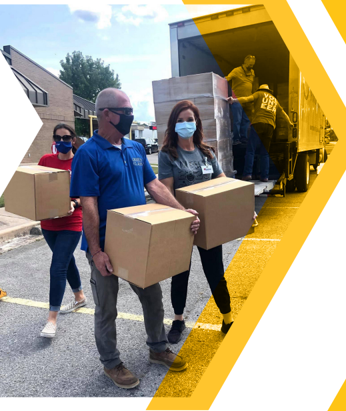

----------------------------------------

Image 2:
  Document ID: 75
  Reference: #/pictures/1
  AI-Generated Description:
    The image features the logo of the Midwest Food Bank. The logo
    consists of a circular design with a yellow background. Inside the
    yellow circle, there is a stylized image of a wheat stalk, which
    is rendered in white. The wheat stalk is positioned such that it
    appears to be growing out of the yellow circle, symbolizing growth
    and agriculture.  To the right of the yellow circle, the text
    "Midwest Food Bank" is written in a bold, black font. The text is
    arranged in three lines, with "Midwest" on the top line, "Food" on
    the middle line, and "Bank" on the bottom line. The font is sans-
    serif, which gives it a modern and clean appearance.  The overall
    design of the logo is simple yet effective, with the use of bright
    colors and clear typography making it easily recognizable. The
    yellow background and white wheat stalk c

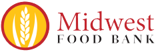

----------------------------------------

Image 3:
  Document ID: 76
  Reference: #/pictures/2
  AI-Generated Description:
    The image contains a text message that reads: "KEEP MOVING
    FORWARD." The text is written in a clear, bold, and slightly
    italicized font. The background of the image is plain and light-
    colored, which makes the text stand out prominently. The text is
    centered horizontally, and the message is concise and direct,
    conveying a motivational message.  ### Analysis and Description
    1. **Text Content**:    - The text reads: "KEEP MOVING FORWARD."
    - The message is motivational, encouraging the reader to continue
    progressing.  2. **Font and Style**:    - The text is in a bold,
    italicized font.    - The use of italicization adds a sense of
    emphasis and importance to the message.    - The boldness of the
    text ensures that it captures attention and is easily readable.
    3. **Background**:    - The background is plain and light-col

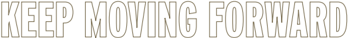

In [22]:
import textwrap

print("\nSample processed documents:")
print("=" * 80)

# Show sample text chunks
print("\nTEXT CHUNK EXAMPLES:")
print("-" * 80)
for i, text_doc in enumerate(texts[:3]):  # Show first 3 text chunks
    print(f"\nText Chunk {i+1}:")
    print(f"  Document ID: {text_doc.metadata['doc_id']}")
    print(f"  Source: {text_doc.metadata['source'].split('/')[-1]}")  # Just filename
    print(f"  Reference: {text_doc.metadata['ref']}")
    print(f"  Has visual grounding: {'dl_meta' in text_doc.metadata}")
    print("  Content preview:")
    print(f"    {text_doc.page_content[:250]}...")
    if i < 2:  # Add separator between examples except after the last one
        print("-" * 40)

# Show sample tables
print("\n\nTABLE EXAMPLES:")
print("-" * 80)
if tables:
    for i, table_doc in enumerate(tables[:3]):  # Show first 3 tables
        print(f"\nTable {i+1}:")
        print(f"  Document ID: {table_doc.metadata['doc_id']}")
        print(f"  Reference: {table_doc.metadata['ref']}")
        print("  Content preview (Markdown format):")
        # Show first few lines of the table
        table_lines = table_doc.page_content.split('\n')[:8]
        for line in table_lines:
            print(f"    {line}")
else:
    print("  No tables found in the document.")

# Show sample images with descriptions
print("\n\nIMAGE EXAMPLES WITH AI-GENERATED DESCRIPTIONS:")
print("-" * 80)
if pictures:
    for i, pic_doc in enumerate(pictures[:3]):  # Show first 3 images
        print(f"\nImage {i+1}:")
        print(f"  Document ID: {pic_doc.metadata['doc_id']}")
        print(f"  Reference: {pic_doc.metadata['ref']}")
        print("  AI-Generated Description:")
        # Wrap the description for better readability
        wrapped_text = textwrap.fill(pic_doc.page_content, width=70, initial_indent="    ", subsequent_indent="    ")
        print(wrapped_text)

        # Display the actual image
        source = pic_doc.metadata['source']
        ref = pic_doc.metadata['ref']
        docling_document = conversions[source]
        picture = RefItem(cref=ref).resolve(docling_document)
        image = picture.get_image(docling_document)
        if image:
            print("\n  Original Image:")
            # Resize image for display if too large
            display_image = image.copy()
            max_width = 600
            if display_image.width > max_width:
                ratio = max_width / display_image.width
                new_height = int(display_image.height * ratio)
                display_image = display_image.resize((max_width, new_height), PIL.Image.Resampling.LANCZOS)
            display(display_image)

        if i < min(2, len(pictures)-1):
            print("-" * 40)
else:
    print("  No images found in the document.")

## Visual Grounding Functions

### Understanding Visual Source Attribution

Visual grounding is what sets this system apart. These functions enable us to:
1. **Locate**: Find the exact source of any retrieved information
2. **Highlight**: Draw visual indicators on document pages
3. **Differentiate**: Use different styles for text, tables, and images
4. **Verify**: Allow users to confirm AI responses against source documents


### Implementing the Core Visual Grounding Function

In [33]:
def visualize_chunk_grounding(chunk, doc_store, highlight_color="blue"):
    """
    Visualize where a text chunk comes from in the original document.

    This function:
    1. Loads the original document from the store
    2. Finds the pages containing the chunk content
    3. Draws bounding boxes around the source regions
    4. Displays the highlighted pages

    Args:
        chunk: LangChain Document with visual grounding metadata
        doc_store: Dictionary mapping document hashes to file paths
        highlight_color: Color for highlighting (blue, green, red, etc.)

    Returns:
        Dictionary of page images with highlights
    """
    # Get the origin hash
    origin_hash = chunk.metadata.get("origin_hash")
    if not origin_hash:
        print("No origin hash found in metadata")
        return None

    # Load the full document from store
    dl_doc = DoclingDocument.load_from_json(doc_store.get(origin_hash))

    print(f"Visualizing source location for chunk {chunk.metadata.get('doc_id', 'Unknown')}")

    # Handle different types of content
    page_images = {}
    item_type = chunk.metadata.get("item_type", "text")

    if item_type in ["picture", "table"] and "prov_data" in chunk.metadata:
        # Handle tables and pictures with simple provenance data
        prov_data = chunk.metadata["prov_data"]

        if not prov_data:
            print(f"No provenance data available for this {item_type}")
            return None

        for prov in prov_data:
            page_no = prov["page_no"]

            # Get page image
            if page_no < len(dl_doc.pages):
                page = dl_doc.pages[page_no]
                if hasattr(page, 'image') and page.image:
                    if page_no not in page_images:
                        img = page.image.pil_image.copy()
                        page_images[page_no] = {
                            'image': img,
                            'page': page,
                            'draw': ImageDraw.Draw(img)
                        }

                    # Draw bounding box
                    draw = page_images[page_no]['draw']
                    bbox = prov["bbox"]

                    # Draw bounding box
                    draw = page_images[page_no]['draw']
                    bbox = prov["bbox"]

                    # The coordinates are already normalized and in top-left origin
                    # Just scale to image dimensions
                    img_width = page_images[page_no]['image'].width
                    img_height = page_images[page_no]['image'].height

                    l = int(bbox["l"] * img_width)
                    r = int(bbox["r"] * img_width)
                    t = int(bbox["t"] * img_height)
                    b = int(bbox["b"] * img_height)

                    # Ensure coordinates are valid (min/max) just in case
                    l, r = min(l, r), max(l, r)
                    t, b = min(t, b), max(t, b)

                    # Clamp to image bounds
                    l = max(0, min(l, img_width - 1))
                    r = max(0, min(r, img_width - 1))
                    t = max(0, min(t, img_height - 1))
                    b = max(0, min(b, img_height - 1))

                    # Draw highlight with different styles for different types
                    if item_type == "picture":
                        draw.rectangle([l, t, r, b], outline=highlight_color, width=4)
                        draw.text((l, t-20), "IMAGE", fill=highlight_color)
                    elif item_type == "table":
                        draw.rectangle([l, t, r, b], outline=highlight_color, width=3)
                        draw.text((l, t-20), "TABLE", fill=highlight_color)

    elif "dl_meta" in chunk.metadata:
        # Handle text chunks with DocMeta
        try:
            meta = DocMeta.model_validate(chunk.metadata["dl_meta"])

            # Process each item in the chunk to find source locations
            for doc_item in meta.doc_items:
                if hasattr(doc_item, 'prov') and doc_item.prov:
                    for prov in doc_item.prov:
                        page_no = prov.page_no

                        # Get or create page image
                        if page_no not in page_images:
                            if page_no < len(dl_doc.pages):
                                page = dl_doc.pages[page_no]
                                if hasattr(page, 'image') and page.image:
                                    img = page.image.pil_image.copy()
                                    page_images[page_no] = {
                                        'image': img,
                                        'page': page,
                                        'draw': ImageDraw.Draw(img)
                                    }

                        # Draw bounding box on the page
                        if page_no in page_images:
                            page_data = page_images[page_no]
                            page = page_data['page']
                            draw = page_data['draw']

                            # Convert coordinates to image space
                            bbox = prov.bbox.to_top_left_origin(page_height=page.size.height)
                            bbox = bbox.normalized(page.size)

                            # Scale to actual image dimensions
                            l = int(bbox.l * page_data['image'].width)
                            r = int(bbox.r * page_data['image'].width)
                            t = int(bbox.t * page_data['image'].height)
                            b = int(bbox.b * page_data['image'].height)

                            # Draw highlight rectangle
                            draw.rectangle([l, t, r, b], outline=highlight_color, width=2)
        except Exception as e:
            print(f"Error processing text chunk metadata: {e}")
            return None
    else:
        print("No visual grounding metadata available for this chunk")
        return None

    # Display highlighted pages
    for page_no, page_data in sorted(page_images.items()):
        plt.figure(figsize=(12, 16))
        plt.imshow(page_data['image'])
        plt.axis('off')

        # Add title indicating content type
        if item_type == "picture":
            title = "Image Location"
        elif item_type == "table":
            title = "Table Location"
        else:
            title = "Text Location"
        plt.title(f'{title} - Page {page_no + 1}', fontsize=16)
        plt.tight_layout()
        plt.show()

    return page_images


## Populate the Vector Database

### Understanding Vector Databases in Multimodal RAG

Vector databases are the search engine of our RAG system. They:
- Store numerical representations (embeddings) of our content
- Enable semantic similarity search
- Maintain all metadata needed for visual grounding
- Support fast retrieval at scale

For multimodal content, this means:
- Text chunks are embedded directly
- Table markdown is embedded for structure search
- AI-generated image descriptions are embedded for visual search


### Choose and Configure Vector Database

We'll use Milvus, a high-performance vector database. For other vector database options, see [this Vector Store recipe](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Components/Langchain_Vector_Stores.ipynb).

In [23]:
# Create a temporary database file
db_file = tempfile.NamedTemporaryFile(prefix="vectorstore_", suffix=".db", delete=False).name
print(f"Vector database will be saved to: {db_file}")

# Initialize Milvus vector store
vector_db: VectorStore = Milvus(
    embedding_function=embeddings_model,
    connection_args={"uri": db_file},
    auto_id=True,
    enable_dynamic_field=True,  # Allows flexible metadata storage
    index_params={"index_type": "AUTOINDEX"},  # Automatic index optimization
)


Vector database will be saved to: /var/folders/cf/wmcbk_7j29z_ts8842l_v6q40000gn/T/vectorstore_4kszsejv.db


/Users/simon/Documents/projects/202510-pycones-docling-workshop/.venv/lib/python3.12/site-packages/milvus_lite/__init__.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Add Documents to Vector Database

Now we'll add all our processed documents (text chunks, tables, and image descriptions) to the vector database:

In [25]:
print("\nAdding documents to vector database...")
documents = list(itertools.chain(texts, tables, pictures))
ids = vector_db.add_documents(documents)
print(f"Successfully added {len(ids)} documents to the vector database")
print(f"  - Text chunks: {len(texts)}")
print(f"  - Tables: {len(tables)}")
print(f"  - Image descriptions: {len(pictures)}")


Adding documents to vector database...
Successfully added 126 documents to the vector database
  - Text chunks: 72
  - Tables: 1
  - Image descriptions: 53


## Test Retrieval with Visual Grounding

### Understanding Retrieval Testing

Before building the full RAG pipeline, let's test that our retrieval and visual grounding work correctly. This helps verify:
- Content is being found based on semantic similarity
- Visual grounding metadata is preserved
- Different content types are handled properly

### Basic Retrieval Test


In [26]:
# Test query
test_query = "How much was spent on food distribution relative to the amount of food distributed?"

print(f"\nTesting retrieval for query: '{test_query}'")
print("=" * 80)

# Retrieve relevant documents
retrieved_docs = vector_db.as_retriever().invoke(test_query)

# Display retrieved documents
for i, doc in enumerate(retrieved_docs):
    print(f"\nRetrieved Document {i+1}:")

    # Determine content type
    item_type = doc.metadata.get('item_type', 'text')
    if item_type == 'picture':
        content_type = "AI-Generated Image Description"
    elif item_type == 'table':
        content_type = "Table (Markdown)"
    else:
        content_type = "Text Chunk"

    print(f"Type: {content_type}")
    print(f"Content preview: {doc.page_content[:200]}...")
    print(f"Source: {doc.metadata['source'].split('/')[-1]}")


Testing retrieval for query: 'How much was spent on food distribution relative to the amount of food distributed?'

Retrieved Document 1:
Type: Text Chunk
Content preview: Midwest Food Bank Growth Value of food distributed (millions) Value of food distributed (millions)...
Source: AR_2020_WEB2.pdf

Retrieved Document 2:
Type: Text Chunk
Content preview: Midwest Food Bank Growth Value of food distributed (millions) Value of food distributed (millions)...
Source: AR_2020_WEB2.pdf

Retrieved Document 3:
Type: AI-Generated Image Description
Content preview: The image contains a graphic that illustrates a relationship between spending and the resulting food distribution. The image is divided into two main sections:

1. **Left Section:**
   - The left sect...
Source: AR_2020_WEB2.pdf

Retrieved Document 4:
Type: AI-Generated Image Description
Content preview: The image contains a graphic that illustrates a relationship between spending and the resulting food distribution. The image is divid

## Enhanced RAG with Visual Grounding - Bringing It All Together


### The Complete Multimodal RAG Pipeline

Now we'll implement the full RAG system that:
1. Retrieves relevant multimodal content
2. Shows exactly where each piece comes from
3. Generates accurate, grounded responses

### Understanding Visual Grounding for Different Content Types

Our system handles three content types distinctly:

1. **Text Chunks**: Standard highlighting shows text passages
2. **Tables**: Thick borders with "TABLE" labels mark structured data
3. **Images**: Distinctive borders with "IMAGE" labels show picture locations

This visual differentiation helps users quickly understand what type of content contributed to the AI's response.

### Implementing the Complete RAG Pipeline

In [31]:
def rag_with_visual_grounding(question, vector_db, doc_store, model, tokenizer, top_k=5):
    """
    Perform RAG with visual grounding of results.

    This function:
    1. Retrieves relevant chunks from the vector database
    2. Visualizes where each chunk comes from in the original document
    3. Generates a response using the retrieved context

    Args:
        question: User's query
        vector_db: Vector database with embedded documents
        doc_store: Document store for visual grounding
        model: Language model for response generation
        tokenizer: Tokenizer for the language model
        top_k: Number of chunks to retrieve

    Returns:
        Tuple of (outputs, relevant_chunks)
    """
    print(f"\nQuestion: {question}")
    print("=" * 80)

    # Step 1: Retrieve relevant chunks
    print(f"\nRetrieving top {top_k} relevant chunks...")
    retriever = vector_db.as_retriever(search_kwargs={"k": top_k})
    relevant_chunks = retriever.invoke(question)

    print(f"Found {len(relevant_chunks)} relevant chunks")

    # Step 2: Visualize each chunk's source location
    print("\nVisualizing source locations:")

    for i, chunk in enumerate(relevant_chunks):
        print(f"\n--- Result {i+1} ---")

        # Determine content type
        item_type = chunk.metadata.get('item_type', 'text')
        if item_type == 'picture':
            content_type = "AI-Generated Image Description"
            color = 'red'
        elif item_type == 'table':
            content_type = "Table (Markdown)"
            color = 'green'
        else:
            content_type = "Text Chunk"
            color = 'blue'

        print(f"Content type: {content_type}")
        print(f"Text preview: {chunk.page_content[:200]}...")
        print(f"Source: {chunk.metadata.get('source', 'Unknown').split('/')[-1]}")

        # Show visual grounding if available
        if "dl_meta" in chunk.metadata or "prov_data" in chunk.metadata:
            visualize_chunk_grounding(
                chunk,
                doc_store,
                highlight_color=color
            )
        else:
            print("  (No visual grounding available for this chunk)")

    # Step 3: Create RAG pipeline for response generation
    print("\nGenerating response with LLM...")

    # Create Granite prompt template
    prompt = tokenizer.apply_chat_template(
        conversation=[{
            "role": "user",
            "content": "{input}",
        }],
        documents=[{
            "doc_id": "0",
            "text": "{context}",
        }],
        add_generation_prompt=True,
        tokenize=False,
    )

    prompt_template = PromptTemplate.from_template(
        template=escape_f_string(prompt, "input", "context")
    )

    # Document prompt template
    document_prompt_template = PromptTemplate.from_template(template="""\
<|end_of_text|>
<|start_of_role|>document {{"document_id": "{doc_id}"}}<|end_of_role|>
{page_content}""")

    # Create chains
    combine_docs_chain = create_stuff_documents_chain(
        llm=model,
        prompt=prompt_template,
        document_prompt=document_prompt_template,
        document_separator="",
    )

    rag_chain = create_retrieval_chain(
        retriever=retriever,
        combine_docs_chain=combine_docs_chain,
    )

    # Generate response
    outputs = rag_chain.invoke({"input": question})

    print("\nGenerated Answer:")
    print("=" * 80)
    print(outputs['answer'])
    print("=" * 80)

    return outputs, relevant_chunks

## Demonstrate the Complete System

### Main Query with Visual Grounding

Let's run our main query and see the complete system in action:


Question: How much was spent compared to the amount of food distributed?

Retrieving top 5 relevant chunks...
Found 5 relevant chunks

Visualizing source locations:

--- Result 1 ---
Content type: Text Chunk
Text preview: Midwest Food Bank Growth Value of food distributed (millions) Value of food distributed (millions)...
Source: AR_2020_WEB2.pdf
Visualizing source location for chunk 15


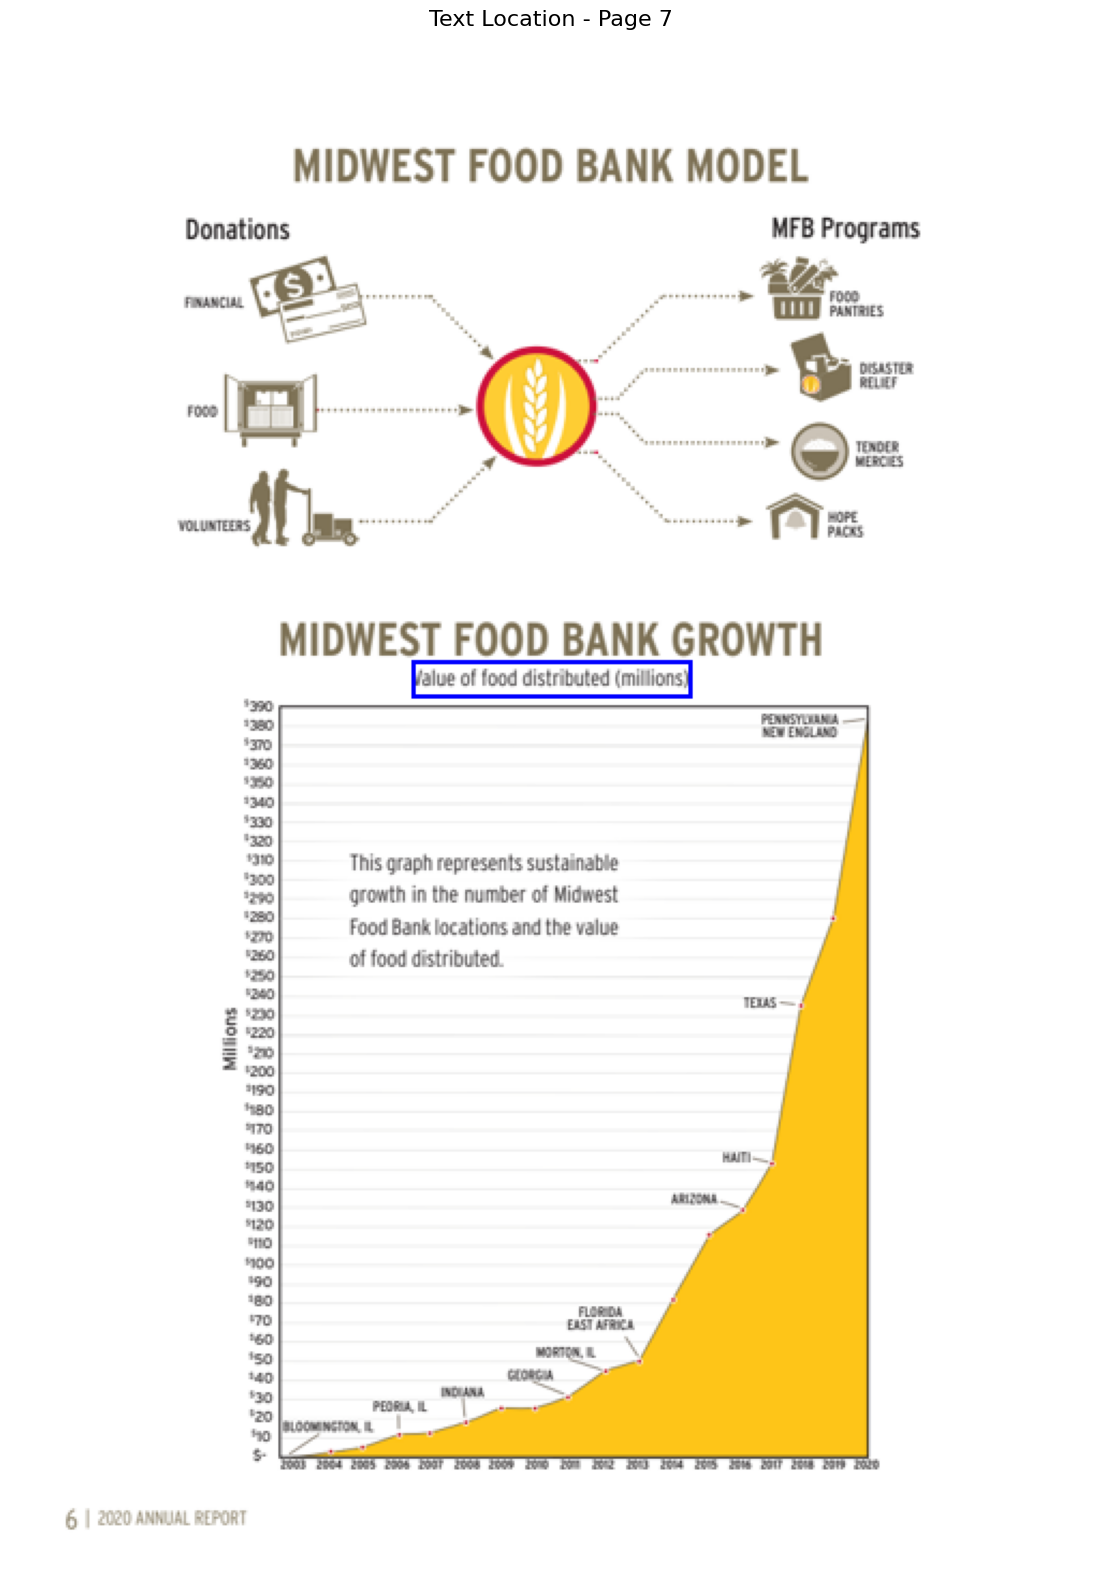


--- Result 2 ---
Content type: Text Chunk
Text preview: Midwest Food Bank Growth Value of food distributed (millions) Value of food distributed (millions)...
Source: AR_2020_WEB2.pdf
Visualizing source location for chunk 15


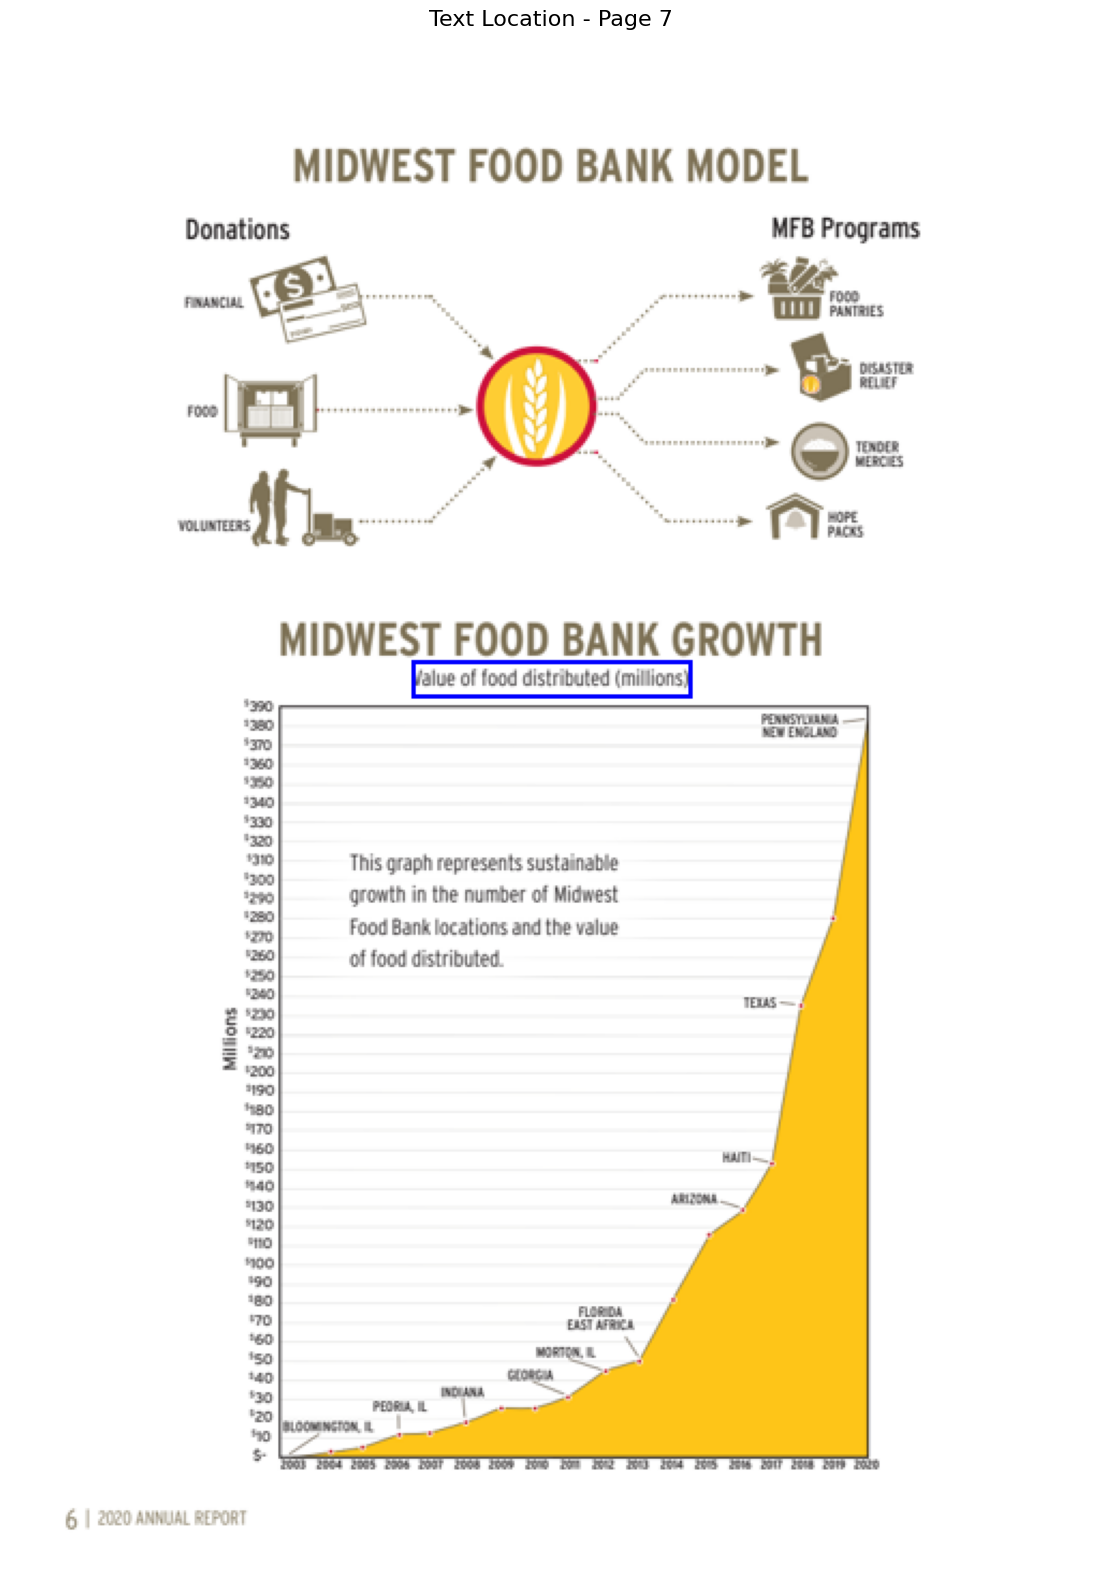


--- Result 3 ---
Content type: AI-Generated Image Description
Text preview: The image contains a graphic that illustrates a relationship between spending and the resulting food distribution. The image is divided into two main sections:

1. **Left Section:**
   - The left sect...
Source: AR_2020_WEB2.pdf
Visualizing source location for chunk 95


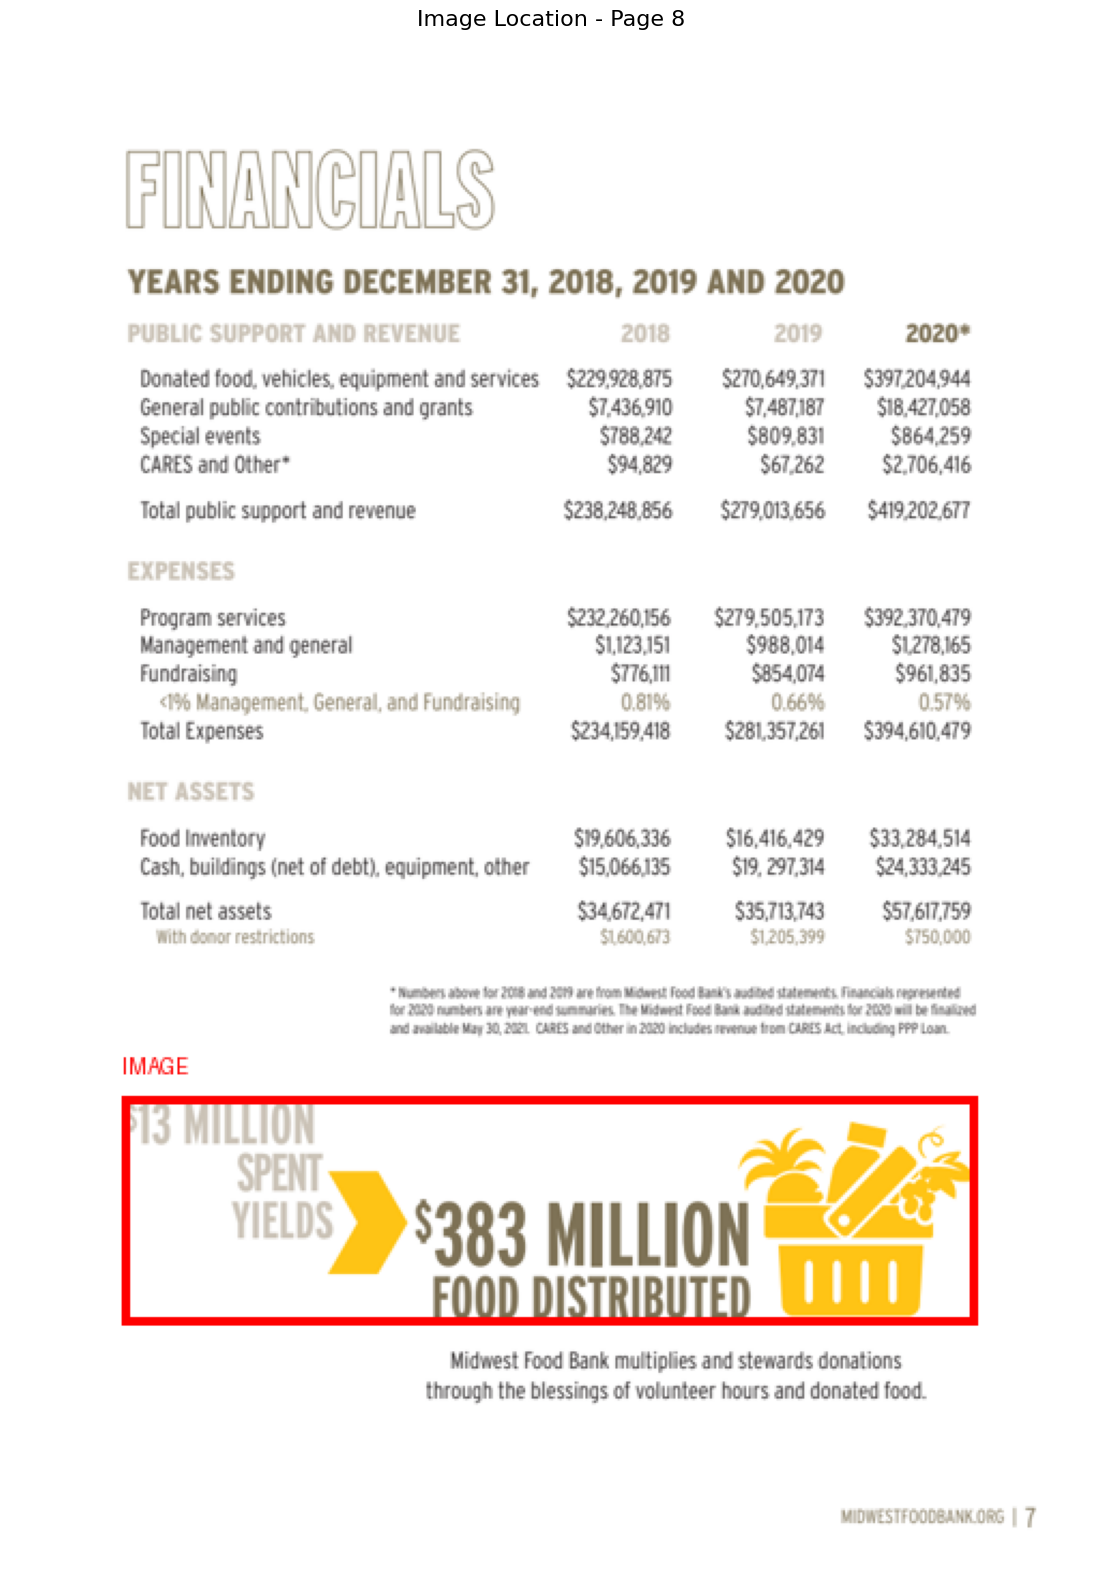


--- Result 4 ---
Content type: AI-Generated Image Description
Text preview: The image contains a graphic that illustrates a relationship between spending and the resulting food distribution. The image is divided into two main sections:

1. **Left Section:**
   - The left sect...
Source: AR_2020_WEB2.pdf
Visualizing source location for chunk 95


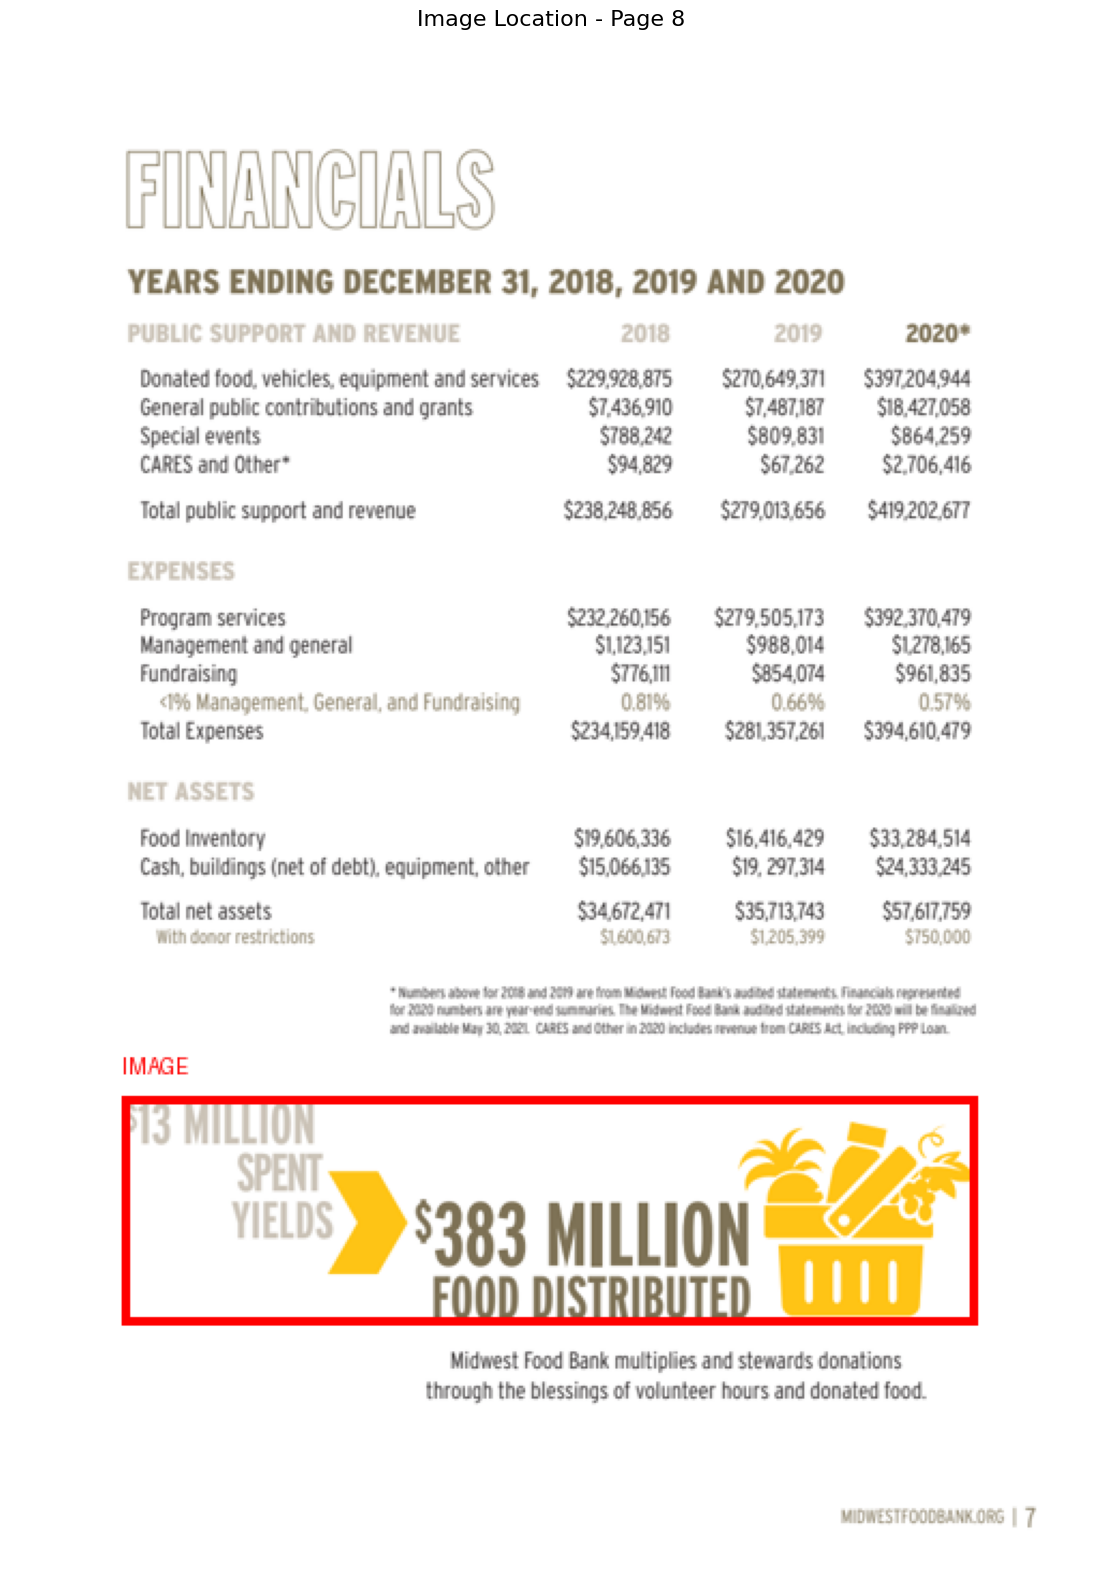


--- Result 5 ---
Content type: Text Chunk
Text preview: Midwest Food Bank is engaged in alleviating hunger and poverty throughout the world. In 2020, Midwest Food  Bank  distributed  over  $383  million  worth of  food  to  over  2,000  non-profit  organiz...
Source: AR_2020_WEB2.pdf
Visualizing source location for chunk 17


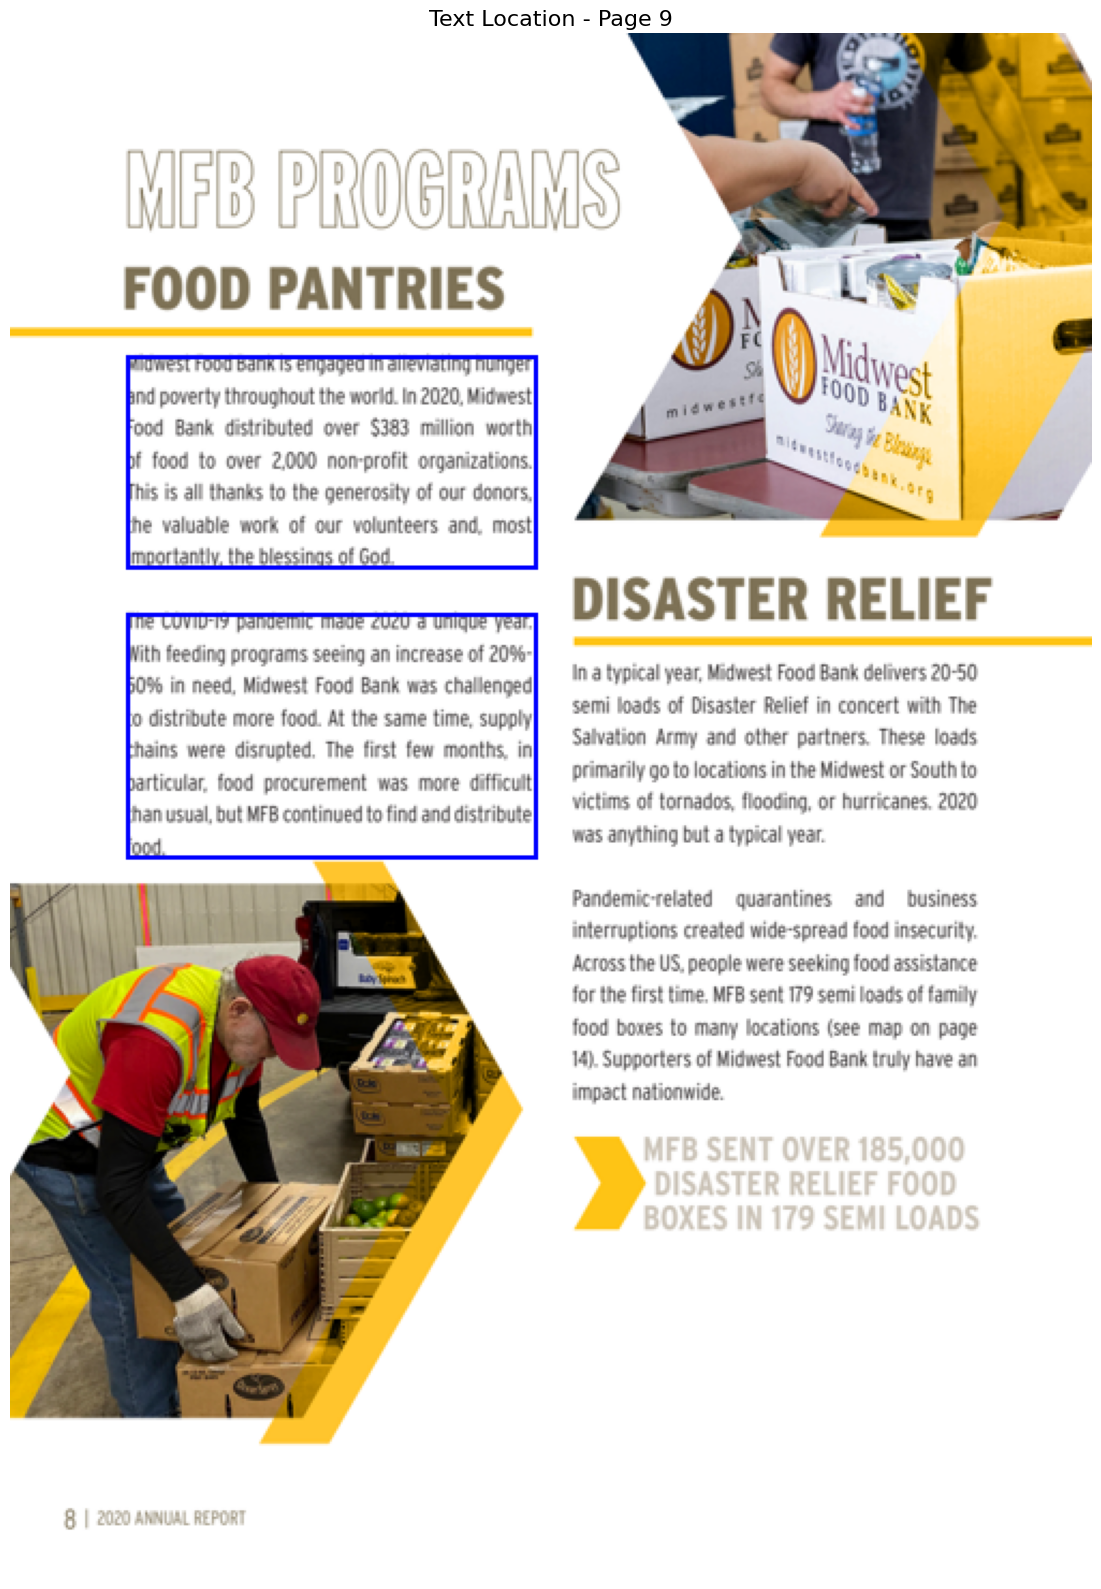


Generating response with LLM...


INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/models/ibm-granite/granite-3.3-8b-instruct "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.replicate.com/v1/models/ibm-granite/granite-3.3-8b-instruct/predictions "HTTP/1.1 201 Created"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/54axqp255xrj00csvxp8tetp4r "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/54axqp255xrj00csvxp8tetp4r "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.replicate.com/v1/predictions/54axqp255xrj00csvxp8tetp4r "HTTP/1.1 200 OK"



Generated Answer:
The image shows that $13 million was spent, which resulted in the distribution of $383 million worth of food. This indicates that the spending was highly efficient in generating a large volume of food distribution. The ratio of food distributed to spending is approximately 30:1. This suggests that for every dollar spent, roughly thirty dollars' worth of food was distributed. This demonstrates the significant impact of the spending on food distribution.

(Note: The actual ratio cannot be precisely calculated without additional context, but the image strongly implies a high level of efficiency.)


In [34]:
main_query = "How much was spent compared to the amount of food distributed?"
outputs, chunks = rag_with_visual_grounding(
    main_query,
    vector_db,
    doc_store,
    model,
    tokenizer
)

# Summary and Next Steps

### What You've Accomplished

Congratulations! You've successfully built an advanced multimodal RAG system with visual grounding. Here's what you've learned:

### Technical Skills Acquired

1. **Visual Grounding Implementation**
   - Configured Docling for visual reference preservation
   - Maintained coordinate metadata through processing pipeline
   - Created visual attribution for all content types

2. **Multimodal Document Processing**
   - Handled text, tables, and images seamlessly
   - Used AI vision models for image understanding
   - Preserved structure while enabling search

3. **Transparent RAG Architecture**
   - Built trust through visual verification
   - Enabled source attribution for every response
   - Created differentiated highlighting for content types

4. **Production-Ready Integration**
   - Combined multiple AI models effectively
   - Implemented robust error handling
   - Created scalable document processing pipeline

### Key Insights from the Workshop Journey

Looking back at all three labs:
- **Lab 1**: Document structure preservation enables everything else
- **Lab 2**: Intelligent chunking optimizes retrieval quality
- **Lab 3**: Visual grounding transforms RAG into transparent AI

Each lab built on the previous, culminating in this advanced system.

### Why Visual Grounding Changes Everything

Traditional RAG systems are "black boxes" - users must trust the AI blindly. Your system:
- **Shows sources**: Every claim can be visually verified
- **Builds trust**: Users see exactly where information comes from
- **Enables audit**: Perfect for regulated industries
- **Reduces hallucination**: Visual verification catches errors

### The Power of Multimodal Understanding

By processing text, tables, and images, your system:
- Captures complete document information
- Enables richer queries and responses
- Handles real-world document complexity
- Provides comprehensive answers


---

## Next Steps: Where to Go from Here

### Immediate Actions

1. **Experiment with Your Documents**
   - Try documents with complex layouts
   - Test with technical diagrams and charts
   - Process multi-page reports with mixed content

2. **Customize for Your Domain**
   ```python
   # Example: Domain-specific image prompts
   medical_prompt = "Describe this medical image, noting any abnormalities or key features"
   financial_prompt = "Analyze this financial chart, identifying trends and key data points"
   ```

3. **Optimize Performance**
   - Batch process documents
   - Implement caching for visual grounding
   - Use GPU acceleration for vision models

---

## Resources for Continued Learning

### Official Documentation
- **[Docling Documentation](https://github.com/docling-project/docling)**: Latest features and updates
- **[IBM Granite Models](https://www.ibm.com/granite/)**: Model cards and capabilities
- **[LangChain Docs](https://python.langchain.com/)**: RAG patterns and best practices
- **[Milvus Documentation](https://milvus.io/docs)**: Vector database optimization

### Community Resources
- Join the Docling community on GitHub
- Share your implementations
- Contribute improvements back to the project

### Related Topics to Explore
- Document Layout Analysis
- Multimodal Embeddings
- Visual Question Answering
- Explainable AI Systems

---

## Final Thoughts

You've completed an incredible journey from basic document conversion to building a sophisticated, transparent AI system. The combination of Docling's document understanding, Granite's AI capabilities, and visual grounding creates a powerful application.

Your multimodal RAG system with visual grounding represents the cutting edge of document AI. Whether you're building for healthcare, legal, financial, or any other domain, you now have the tools to create AI systems that are not just powerful, but trustworthy and transparent.